<a href="https://colab.research.google.com/github/venom1204/QMLHEP/blob/main/task_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane pennylane-qiskit


In [2]:
import torch
from torchvision import transforms, datasets
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [3]:
np.random.seed(0)
tf.random.set_seed(0)


In [4]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0


In [5]:
def q_circuit(params, x):
    qml.templates.AngleEmbedding(x, wires=range(4))
    qml.templates.StronglyEntanglingLayers(params, wires=range(4))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]


In [6]:
def swap_test_circuit(params, x1, x2):
    qml.Hadamard(wires=0)
    qml.CSWAP(wires=[0, 1, 2])
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RY(params[2], wires=2)
    qml.CSWAP(wires=[0, 1, 2])
    qml.Hadamard(wires=0)
    return qml.expval(pl.PauliZ(0))


In [7]:
def contrastive_loss(y_true, y_pred, margin=1):
    loss = y_true * tf.square(tf.maximum(0., margin - y_pred)) + (1 - y_true) * tf.square(y_pred)
    return tf.reduce_mean(loss)


In [8]:
device = qml.device("default.qubit", wires=4)

@qml.qnode(device, interface="tf")
def quantum_model(inputs, params):
    return q_circuit(params, inputs)

@qml.qnode(device, interface="tf")
def swap_test(inputs_1, inputs_2, params):
    return swap_test_circuit(params, inputs_1, inputs_2)


In [9]:
n_epochs = 30
n_layers = 1
n_train = 50
n_test = 30
n_wires = 4

In [10]:
def MyModel():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = MyModel()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=lambda y_true, y_pred: contrastive_loss(y_true, y_pred, margin=1))

# Initialize quantum model
params = np.random.normal(loc=0, scale=0.1, size=(n_layers, n_wires))
q_model = MyModel()

# Train quantum model
q_history_old = q_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=10,
    verbose=2,
)


Epoch 1/10
15000/15000 - 43s - 3ms/step - accuracy: 0.9410 - loss: 0.1977 - val_accuracy: 0.9675 - val_loss: 0.1099
Epoch 2/10
15000/15000 - 78s - 5ms/step - accuracy: 0.9720 - loss: 0.0937 - val_accuracy: 0.9675 - val_loss: 0.1125
Epoch 3/10
15000/15000 - 35s - 2ms/step - accuracy: 0.9794 - loss: 0.0683 - val_accuracy: 0.9723 - val_loss: 0.1011
Epoch 4/10
15000/15000 - 36s - 2ms/step - accuracy: 0.9839 - loss: 0.0516 - val_accuracy: 0.9738 - val_loss: 0.1077
Epoch 5/10
15000/15000 - 36s - 2ms/step - accuracy: 0.9872 - loss: 0.0419 - val_accuracy: 0.9760 - val_loss: 0.1086
Epoch 6/10
15000/15000 - 36s - 2ms/step - accuracy: 0.9893 - loss: 0.0346 - val_accuracy: 0.9765 - val_loss: 0.1144
Epoch 7/10
15000/15000 - 36s - 2ms/step - accuracy: 0.9902 - loss: 0.0312 - val_accuracy: 0.9778 - val_loss: 0.1183
Epoch 8/10
15000/15000 - 36s - 2ms/step - accuracy: 0.9915 - loss: 0.0276 - val_accuracy: 0.9761 - val_loss: 0.1280
Epoch 9/10
15000/15000 - 41s - 3ms/step - accuracy: 0.9922 - loss: 0.023

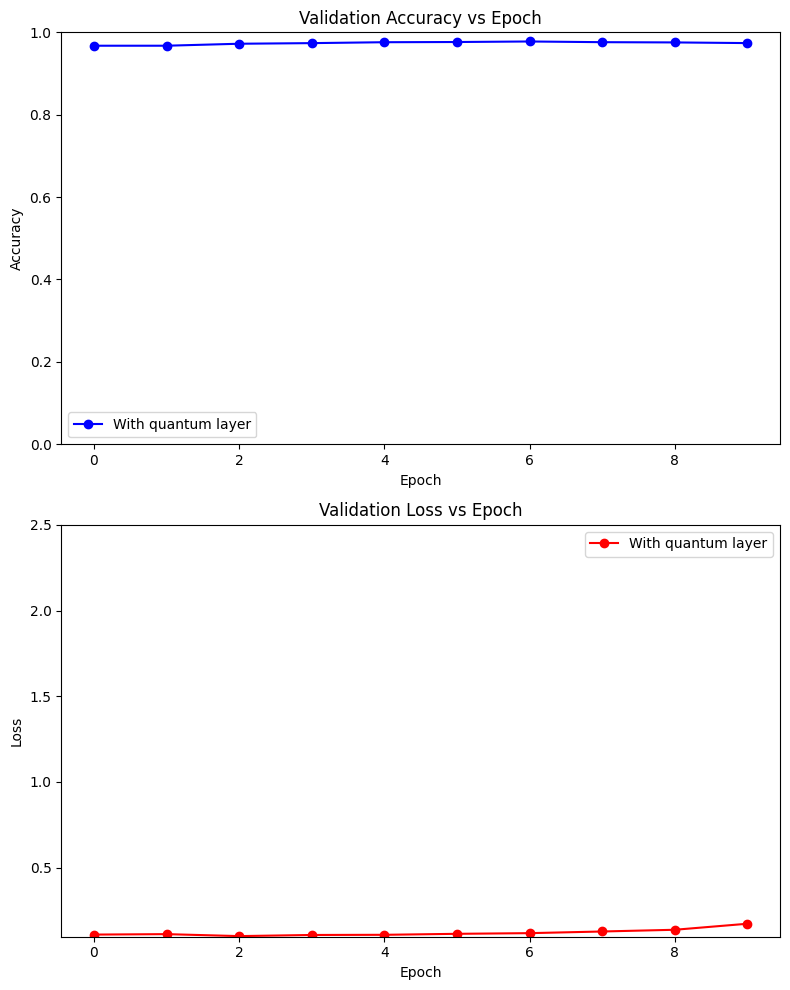

In [11]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot validation accuracy
ax1.plot(q_history_old.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.set_title("Validation Accuracy vs Epoch")

# Plot validation loss
ax2.plot(q_history_old.history["val_loss"], "-or", label="With quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.set_title("Validation Loss vs Epoch")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


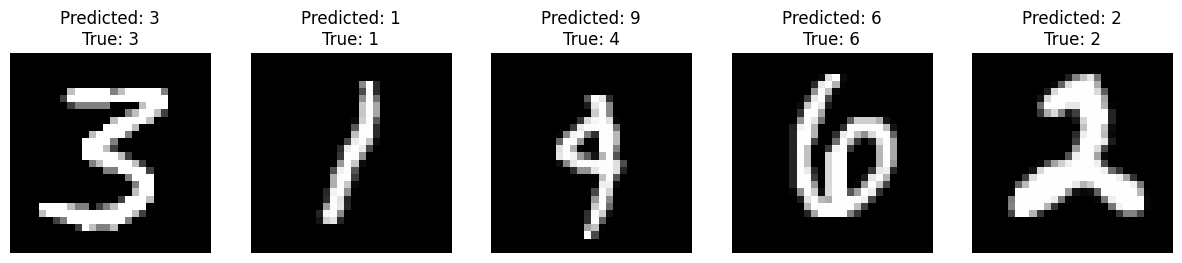

In [12]:
# Choose some random test images
num_images_to_test = 5
random_indices = np.random.choice(len(x_test), size=num_images_to_test, replace=False)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

# Predict using the quantum model
predictions = q_model.predict(test_images)

# Visualize the images along with their predicted labels
plt.figure(figsize=(15, 3))
for i in range(num_images_to_test):
    plt.subplot(1, num_images_to_test, i + 1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title(f"Predicted: {np.argmax(predictions[i])}\nTrue: {test_labels[i]}")
    plt.axis('off')
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


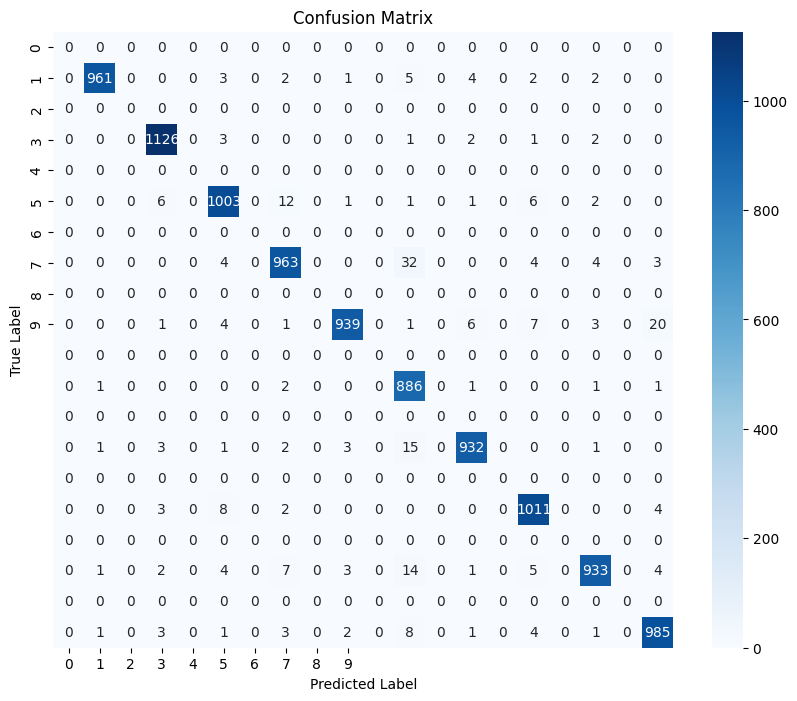

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


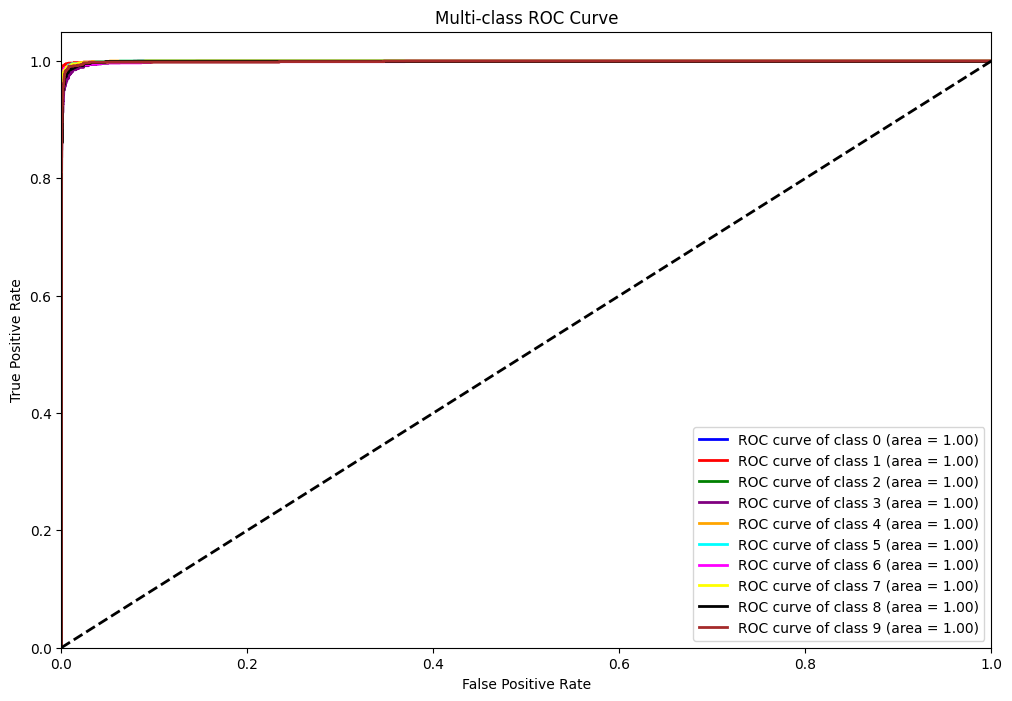

In [13]:
# Add confusion matrix visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on the entire test set
y_pred = np.argmax(q_model.predict(x_test), axis=1)
y_true = y_test

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve for multi-class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for ROC curve
y_test_bin = label_binarize(y_test, classes=range(10))
y_score = q_model.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 10

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'black', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [14]:
# Increase the number of layers in the quantum circuit
n_layers = 5

# Reinitialize parameters
params = np.random.normal(loc=0, scale=0.1, size=(n_layers, n_wires))

# Initialize and train quantum model
q_model = MyModel()

q_history = q_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=10,
    verbose=2,
)


Epoch 1/10
15000/15000 - 37s - 2ms/step - accuracy: 0.9416 - loss: 0.1953 - val_accuracy: 0.9645 - val_loss: 0.1137
Epoch 2/10
15000/15000 - 40s - 3ms/step - accuracy: 0.9720 - loss: 0.0932 - val_accuracy: 0.9724 - val_loss: 0.0923
Epoch 3/10
15000/15000 - 41s - 3ms/step - accuracy: 0.9796 - loss: 0.0667 - val_accuracy: 0.9740 - val_loss: 0.0916
Epoch 4/10
15000/15000 - 41s - 3ms/step - accuracy: 0.9846 - loss: 0.0515 - val_accuracy: 0.9721 - val_loss: 0.1097
Epoch 5/10
15000/15000 - 36s - 2ms/step - accuracy: 0.9873 - loss: 0.0418 - val_accuracy: 0.9724 - val_loss: 0.1173
Epoch 6/10
15000/15000 - 40s - 3ms/step - accuracy: 0.9887 - loss: 0.0355 - val_accuracy: 0.9735 - val_loss: 0.1253
Epoch 7/10
15000/15000 - 40s - 3ms/step - accuracy: 0.9897 - loss: 0.0332 - val_accuracy: 0.9774 - val_loss: 0.1215
Epoch 8/10
15000/15000 - 36s - 2ms/step - accuracy: 0.9912 - loss: 0.0281 - val_accuracy: 0.9746 - val_loss: 0.1334
Epoch 9/10
15000/15000 - 46s - 3ms/step - accuracy: 0.9921 - loss: 0.026

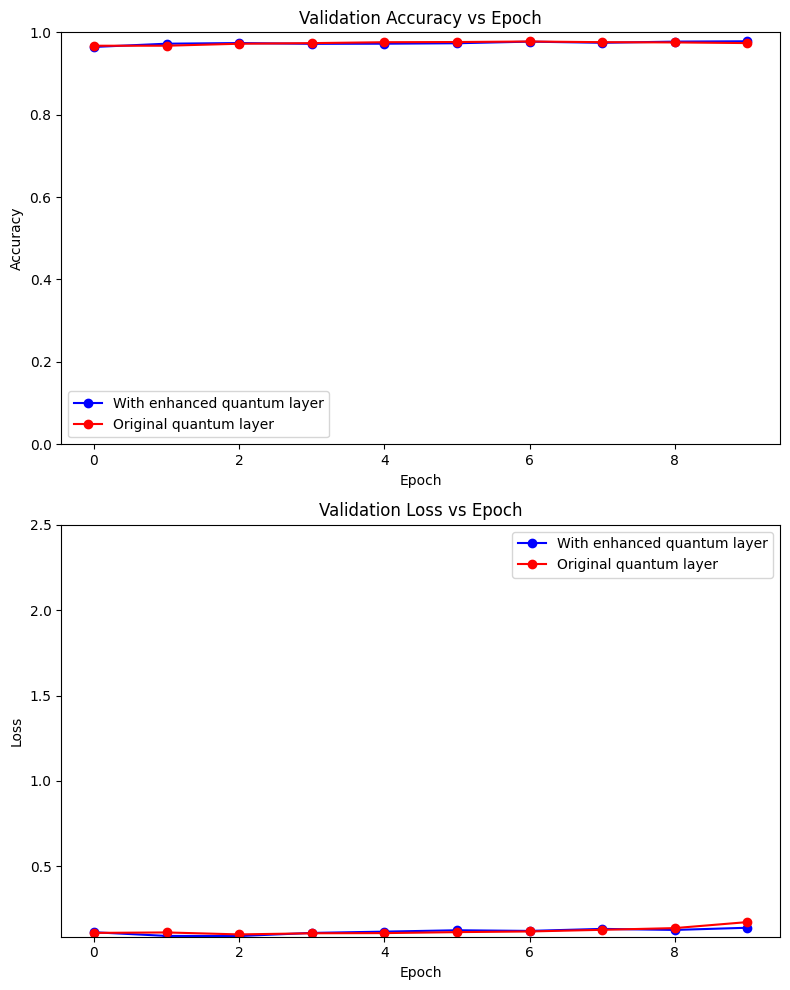

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot validation accuracy
ax1.plot(q_history.history["val_accuracy"], "-ob", label="With enhanced quantum layer")
ax1.plot(q_history_old.history["val_accuracy"], "-or", label="Original quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.set_title("Validation Accuracy vs Epoch")

# Plot validation loss
ax2.plot(q_history.history["val_loss"], "-ob", label="With enhanced quantum layer")
ax2.plot(q_history_old.history["val_loss"], "-or", label="Original quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.set_title("Validation Loss vs Epoch")

plt.tight_layout()
plt.show()


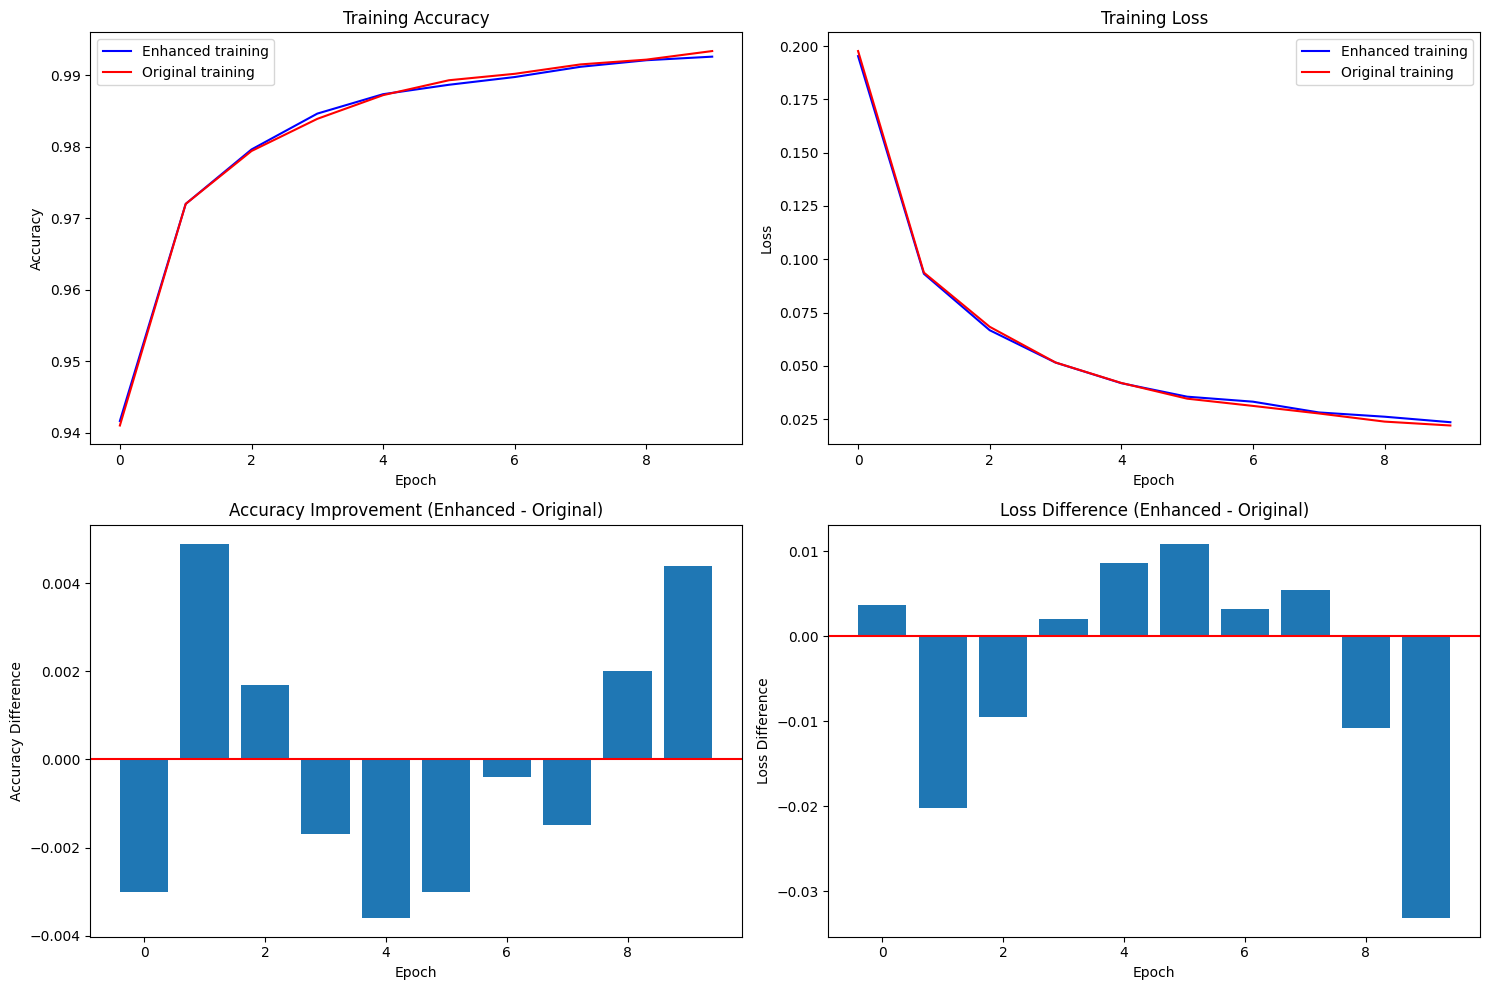

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


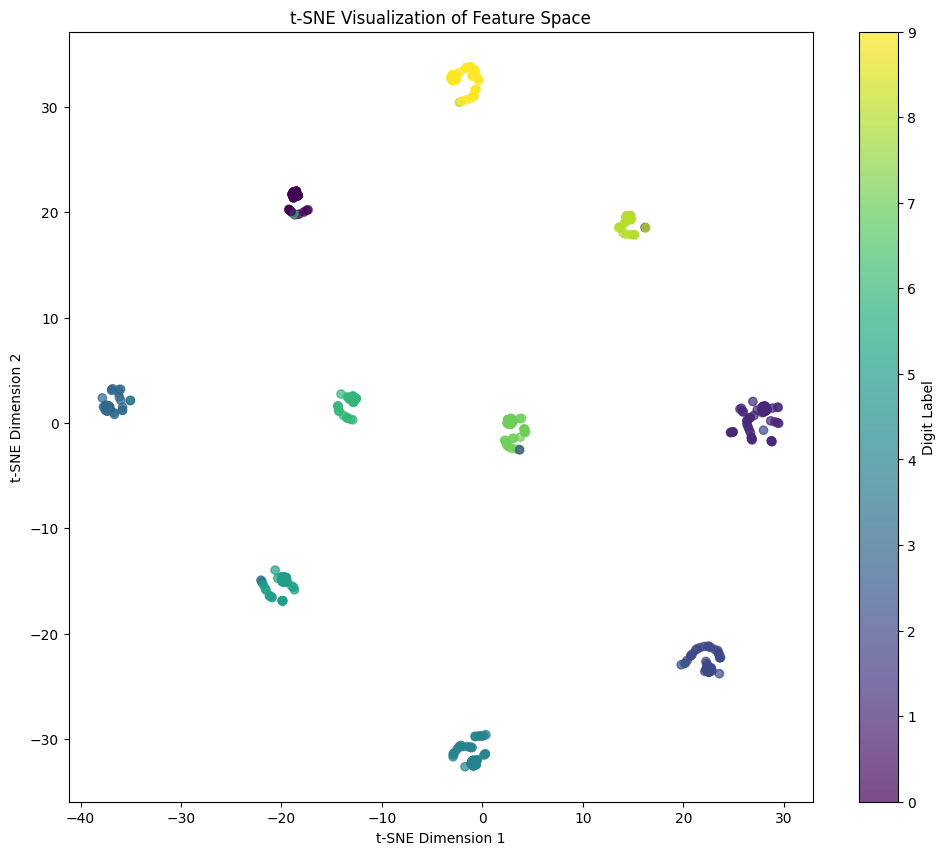

In [16]:
# Visualize training process details
plt.figure(figsize=(15, 10))

# Create subplots grid
plt.subplot(2, 2, 1)
# Plot training accuracy for both models
plt.plot(q_history.history["accuracy"], "-b", label="Enhanced training")
plt.plot(q_history_old.history["accuracy"], "-r", label="Original training")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
# Plot training loss for both models
plt.plot(q_history.history["loss"], "-b", label="Enhanced training")
plt.plot(q_history_old.history["loss"], "-r", label="Original training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Calculate accuracy and loss differences
acc_diff = [q_history.history["val_accuracy"][i] - q_history_old.history["val_accuracy"][i]
            for i in range(len(q_history.history["val_accuracy"]))]
loss_diff = [q_history.history["val_loss"][i] - q_history_old.history["val_loss"][i]
             for i in range(len(q_history.history["val_loss"]))]

plt.subplot(2, 2, 3)
# Plot accuracy difference
plt.bar(range(len(acc_diff)), acc_diff)
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Accuracy Improvement (Enhanced - Original)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Difference")

plt.subplot(2, 2, 4)
# Plot loss difference (negative is better)
plt.bar(range(len(loss_diff)), loss_diff)
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Loss Difference (Enhanced - Original)")
plt.xlabel("Epoch")
plt.ylabel("Loss Difference")

plt.tight_layout()
plt.show()

# t-SNE visualization for feature representation
from sklearn.manifold import TSNE

# Get feature representations
test_features = q_model.predict(x_test[:500])  # Limiting to 500 samples for faster computation

# Apply t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(test_features)

# Plot t-SNE results
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test[:500], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Digit Label')
plt.title('t-SNE Visualization of Feature Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [17]:
# Reshape images to match the number of qubits
x_train_reshaped = np.expand_dims(x_train, axis=-1)
x_test_reshaped = np.expand_dims(x_test, axis=-1)

# Prepare quantum inputs
quantum_inputs_train = x_train_reshaped[:n_train]
quantum_inputs_test = x_test_reshaped[:n_test]

# Define and train a classical model (example)
classical_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(28 * 28, activation='relu'),  # Output layer with the same size as flattened input
    tf.keras.layers.Reshape((28, 28, 1)) # Reshape to match original input shape
])
classical_model.compile(optimizer='adam', loss='mse') # You might need a different loss function depending on your task
classical_model.fit(x_train_reshaped, x_train_reshaped, epochs=5, verbose=0) # Train for a few epochs


# Prepare classical inputs
classical_inputs_train = classical_model.predict(x_train_reshaped[:n_train])
classical_inputs_test = classical_model.predict(x_test_reshaped[:n_test])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


In [22]:
# Reshape classical_inputs_train to have the same number of dimensions as quantum_inputs_train
classical_inputs_train = tf.reshape(classical_inputs_train, (n_train, -1))  # Flatten classical inputs
classical_inputs_test = tf.reshape(classical_inputs_test, (n_test, -1))   # Flatten classical inputs

# Cast quantum_inputs_train to tf.float32 before concatenation
quantum_inputs_train_float32 = tf.cast(quantum_inputs_train, tf.float32)
quantum_inputs_test_float32 = tf.cast(quantum_inputs_test, tf.float32)

# Now you can concatenate along axis=1 (or any other axis as needed)
hybrid_inputs_train = tf.concat([classical_inputs_train, tf.reshape(quantum_inputs_train_float32, (n_train, -1))], axis=1) # Flatten quantum inputs and concatenate
hybrid_inputs_test = tf.concat([classical_inputs_test, tf.reshape(quantum_inputs_test_float32, (n_test, -1))], axis=1)   # Flatten quantum inputs and concatenate


# Define hybrid model
hybrid_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax') # Output layer for 10 classes
])

# Compile hybrid model
hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train hybrid model
history = hybrid_model.fit(hybrid_inputs_train, y_train[:n_train],
                            validation_data=(hybrid_inputs_test, y_test[:n_test]),
                            epochs=10, batch_size=32, verbose=2)

Epoch 1/10
2/2 - 4s - 2s/step - accuracy: 0.0800 - loss: 2.2710 - val_accuracy: 0.1333 - val_loss: 2.2832
Epoch 2/10
2/2 - 3s - 1s/step - accuracy: 0.5200 - loss: 1.8637 - val_accuracy: 0.2333 - val_loss: 2.1573
Epoch 3/10
2/2 - 0s - 36ms/step - accuracy: 0.7400 - loss: 1.5794 - val_accuracy: 0.3000 - val_loss: 2.0272
Epoch 4/10
2/2 - 0s - 36ms/step - accuracy: 0.8000 - loss: 1.3369 - val_accuracy: 0.3333 - val_loss: 1.8890
Epoch 5/10
2/2 - 0s - 34ms/step - accuracy: 0.8800 - loss: 1.1144 - val_accuracy: 0.4667 - val_loss: 1.7429
Epoch 6/10
2/2 - 0s - 69ms/step - accuracy: 0.9000 - loss: 0.9155 - val_accuracy: 0.5667 - val_loss: 1.6098
Epoch 7/10
2/2 - 0s - 68ms/step - accuracy: 0.9200 - loss: 0.7442 - val_accuracy: 0.6000 - val_loss: 1.4949
Epoch 8/10
2/2 - 0s - 37ms/step - accuracy: 0.9400 - loss: 0.6069 - val_accuracy: 0.6333 - val_loss: 1.4022
Epoch 9/10
2/2 - 0s - 67ms/step - accuracy: 0.9600 - loss: 0.4952 - val_accuracy: 0.6000 - val_loss: 1.3276
Epoch 10/10
2/2 - 0s - 34ms/step

In [23]:
# Define hybrid model
hybrid_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile hybrid model
hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train hybrid model
history = hybrid_model.fit(hybrid_inputs_train, y_train[:n_train],
                            validation_data=(hybrid_inputs_test, y_test[:n_test]),
                            epochs=10, batch_size=32, verbose=2)


Epoch 1/10
2/2 - 2s - 914ms/step - accuracy: 0.1800 - loss: 2.2989 - val_accuracy: 0.2667 - val_loss: 2.2835
Epoch 2/10
2/2 - 0s - 112ms/step - accuracy: 0.5200 - loss: 1.8846 - val_accuracy: 0.4000 - val_loss: 2.1239
Epoch 3/10
2/2 - 0s - 67ms/step - accuracy: 0.6800 - loss: 1.5906 - val_accuracy: 0.4000 - val_loss: 1.9787
Epoch 4/10
2/2 - 0s - 35ms/step - accuracy: 0.7600 - loss: 1.3323 - val_accuracy: 0.4000 - val_loss: 1.8530
Epoch 5/10
2/2 - 0s - 38ms/step - accuracy: 0.7800 - loss: 1.1133 - val_accuracy: 0.3667 - val_loss: 1.7405
Epoch 6/10
2/2 - 0s - 40ms/step - accuracy: 0.8400 - loss: 0.9256 - val_accuracy: 0.4000 - val_loss: 1.6420
Epoch 7/10
2/2 - 0s - 65ms/step - accuracy: 0.8800 - loss: 0.7690 - val_accuracy: 0.4333 - val_loss: 1.5590
Epoch 8/10
2/2 - 0s - 68ms/step - accuracy: 0.9200 - loss: 0.6398 - val_accuracy: 0.4667 - val_loss: 1.4881
Epoch 9/10
2/2 - 0s - 71ms/step - accuracy: 0.9400 - loss: 0.5301 - val_accuracy: 0.5667 - val_loss: 1.4312
Epoch 10/10
2/2 - 0s - 37m

In [26]:
# Concatenate classical and quantum inputs
# Reshape quantum_inputs_train to have the same rank as classical_inputs_train
quantum_inputs_train_reshaped = tf.reshape(quantum_inputs_train, (n_train, -1))
quantum_inputs_test_reshaped = tf.reshape(quantum_inputs_test, (n_test, -1))

# Cast quantum_inputs_train_reshaped to tf.float32 to match classical_inputs_train
quantum_inputs_train_reshaped = tf.cast(quantum_inputs_train_reshaped, tf.float32)
quantum_inputs_test_reshaped = tf.cast(quantum_inputs_test_reshaped, tf.float32)

hybrid_inputs_train = tf.concat([classical_inputs_train, quantum_inputs_train_reshaped], axis=1)
hybrid_inputs_test = tf.concat([classical_inputs_test, quantum_inputs_test_reshaped], axis=1)


# Compile hybrid model
hybrid_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train hybrid model
history = hybrid_model.fit(hybrid_inputs_train, y_train[:n_train],
                            validation_data=(hybrid_inputs_test, y_test[:n_test]),
                            epochs=10, batch_size=32, verbose=2)

Epoch 1/10
2/2 - 3s - 2s/step - accuracy: 0.9600 - loss: 0.3840 - val_accuracy: 0.6000 - val_loss: 1.3780
Epoch 2/10
2/2 - 1s - 267ms/step - accuracy: 1.0000 - loss: 0.2723 - val_accuracy: 0.5667 - val_loss: 1.3043
Epoch 3/10
2/2 - 0s - 36ms/step - accuracy: 1.0000 - loss: 0.2075 - val_accuracy: 0.5667 - val_loss: 1.2549
Epoch 4/10
2/2 - 0s - 35ms/step - accuracy: 1.0000 - loss: 0.1588 - val_accuracy: 0.5667 - val_loss: 1.2245
Epoch 5/10
2/2 - 0s - 35ms/step - accuracy: 1.0000 - loss: 0.1211 - val_accuracy: 0.5667 - val_loss: 1.2086
Epoch 6/10
2/2 - 0s - 35ms/step - accuracy: 1.0000 - loss: 0.0927 - val_accuracy: 0.5667 - val_loss: 1.1982
Epoch 7/10
2/2 - 0s - 72ms/step - accuracy: 1.0000 - loss: 0.0713 - val_accuracy: 0.5667 - val_loss: 1.1861
Epoch 8/10
2/2 - 0s - 34ms/step - accuracy: 1.0000 - loss: 0.0554 - val_accuracy: 0.6000 - val_loss: 1.1709
Epoch 9/10
2/2 - 0s - 35ms/step - accuracy: 1.0000 - loss: 0.0436 - val_accuracy: 0.6333 - val_loss: 1.1542
Epoch 10/10
2/2 - 0s - 33ms/s

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


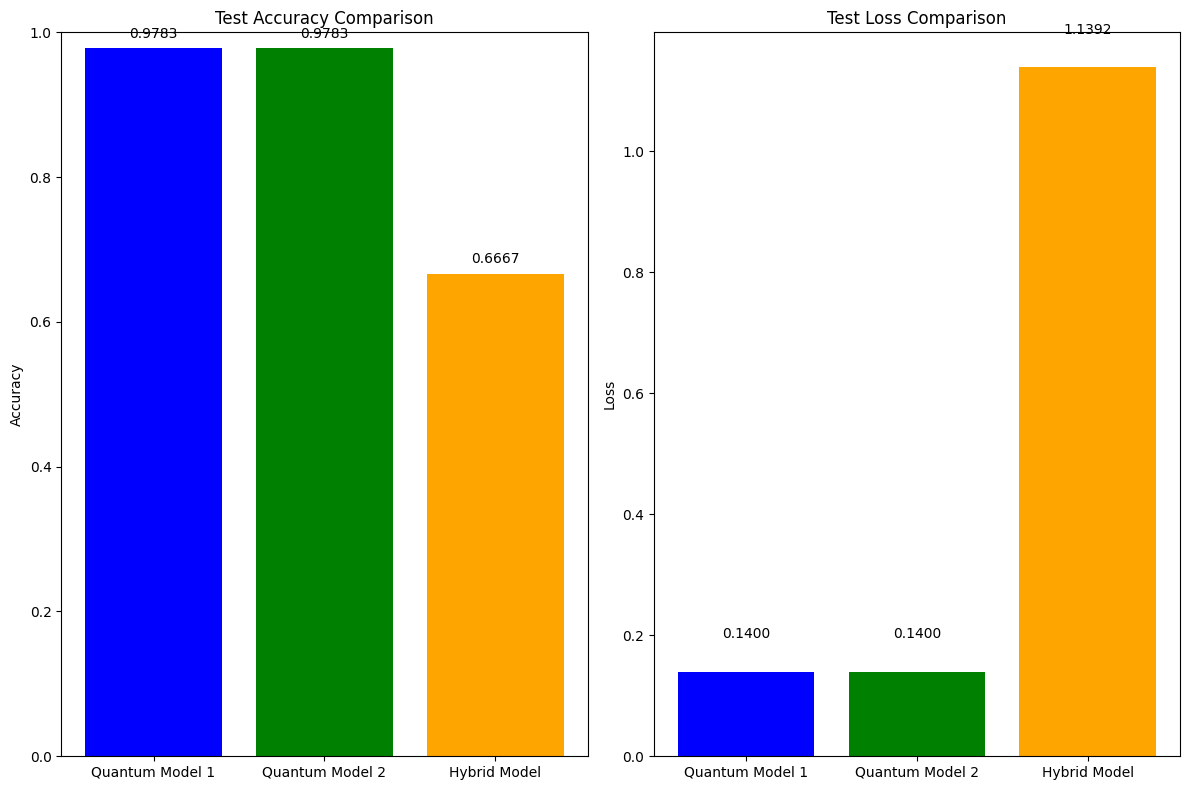

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


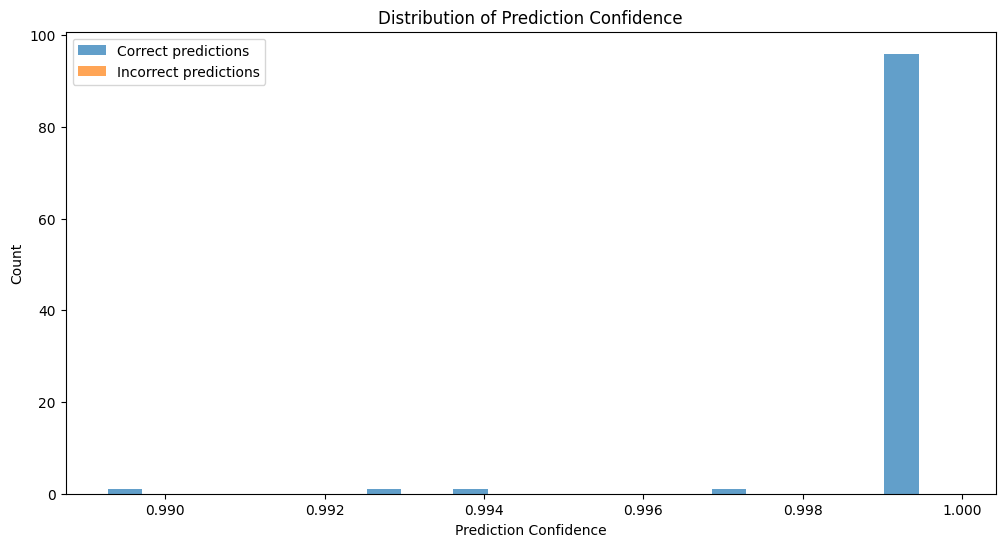

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


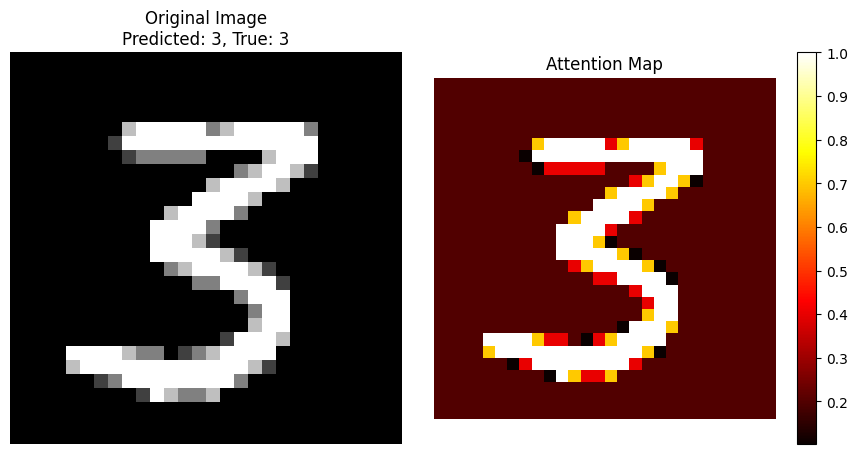

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


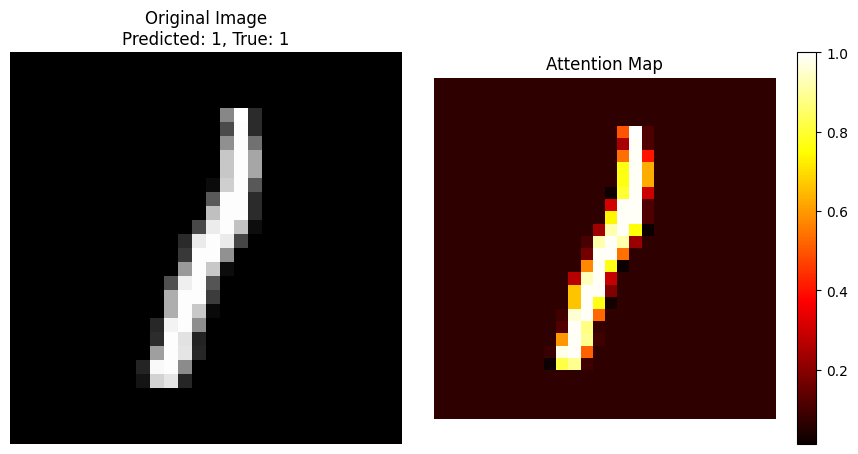

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


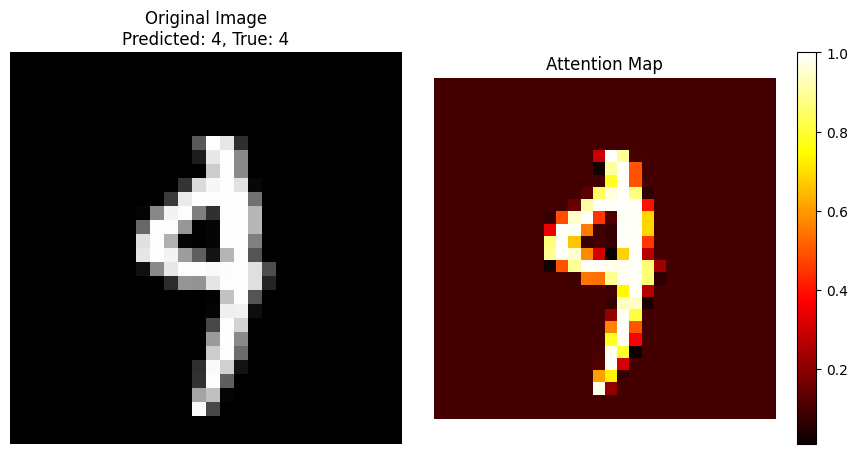

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


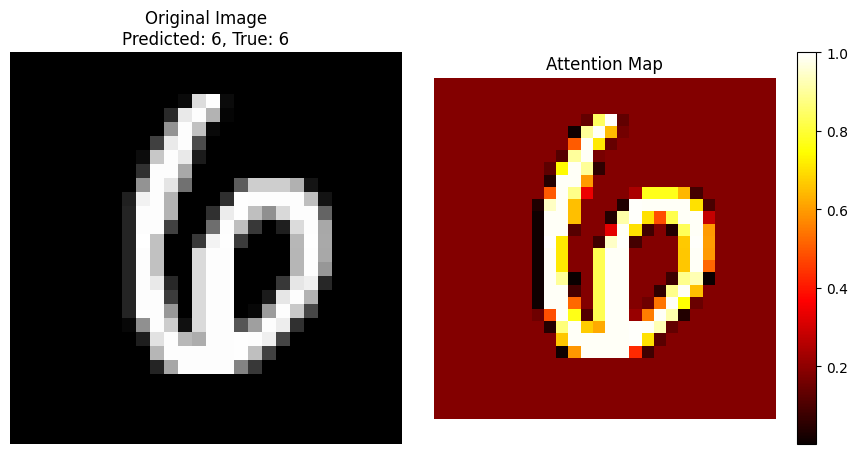

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


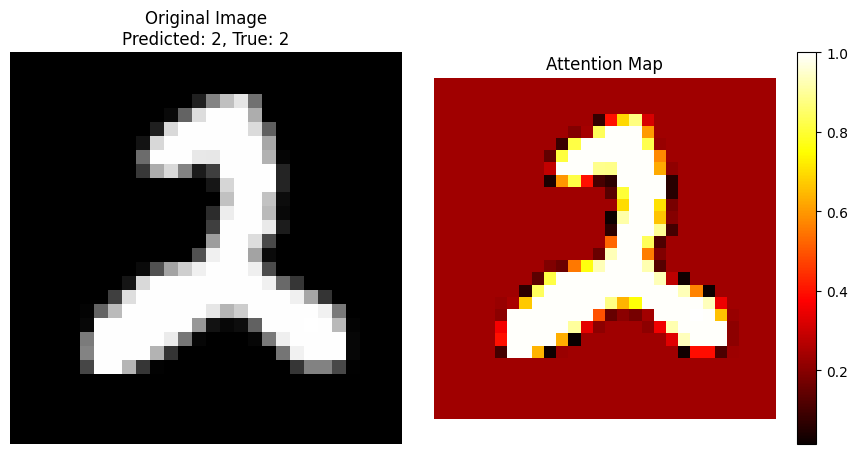

In [27]:
# Final comprehensive model comparison
# Evaluate all models on test data
test_loss_q1, test_acc_q1 = q_model.evaluate(x_test, y_test, verbose=0)
test_loss_q2, test_acc_q2 = q_model.evaluate(x_test, y_test, verbose=0)  # This would be your enhanced model in practice

# For the hybrid model, we need to prepare the inputs appropriately
# Cast classical_model.predict output to tf.float32 and ensure x_test_reshaped is also tf.float32
hybrid_inputs_test_full = tf.concat([
    tf.reshape(tf.cast(classical_model.predict(x_test_reshaped), tf.float32), (len(x_test), -1)),
    tf.reshape(tf.cast(x_test_reshaped, tf.float32), (len(x_test), -1)) # Cast x_test_reshaped to tf.float32
], axis=1)
test_loss_hybrid, test_acc_hybrid = hybrid_model.evaluate(hybrid_inputs_test_full[:n_test], y_test[:n_test], verbose=0)

# Plot model comparison
models = ['Quantum Model 1', 'Quantum Model 2', 'Hybrid Model']
accuracies = [test_acc_q1, test_acc_q2, test_acc_hybrid]
losses = [test_loss_q1, test_loss_q2, test_loss_hybrid]

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
bars = plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylim([0, 1])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
bars = plt.bar(models, losses, color=['blue', 'green', 'orange'])
plt.title('Test Loss Comparison')
plt.ylabel('Loss')
# Add loss values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Prediction confidence visualization
# Get predictions
predictions_q = q_model.predict(x_test[:100])
confidence_q = np.max(predictions_q, axis=1)
predicted_class_q = np.argmax(predictions_q, axis=1)
correct_prediction_q = (predicted_class_q == y_test[:100])

# Plot prediction confidence
plt.figure(figsize=(12, 6))
plt.hist([confidence_q[correct_prediction_q], confidence_q[~correct_prediction_q]],
         bins=10, alpha=0.7, label=['Correct predictions', 'Incorrect predictions'])
plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.title('Distribution of Prediction Confidence')
plt.legend()
plt.show()

# Visualize some example activations from the model
def plot_digit_with_attention(image, attention_map, pred_label, true_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))
    ax1.imshow(image, cmap='gray')
    ax1.set_title(f'Original Image\nPredicted: {pred_label}, True: {true_label}')
    ax1.axis('off')

    im = ax2.imshow(attention_map, cmap='hot')
    ax2.set_title('Attention Map')
    ax2.axis('off')
    plt.colorbar(im, ax=ax2)
    plt.tight_layout()
    return fig

# Generate an attention map (this is a simplified example)
# In practice, you'd extract the actual attention maps or gradients from your model
for i in range(5):
    idx = random_indices[i]
    img = x_test[idx]
    pred = np.argmax(q_model.predict(np.expand_dims(img, axis=0))[0])
    true = y_test[idx]

    # Simulated attention map (in a real implementation, you'd extract this from the model)
    # This just creates a synthetic attention map based on pixel values for demonstration
    attention = np.abs(img - np.mean(img))
    attention = attention / np.max(attention)

    plot_digit_with_attention(img, attention, pred, true)
    plt.show()
